# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

In [8]:
import pandas as pd
import numpy as np
import warnings
import time

from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt 

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import xgboost as xgb

random = 42
warnings.filterwarnings("ignore")

In [9]:
data_og = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data_og.sort_index(inplace=True)
data_og = data_og.resample('1H').sum()

In [10]:
data_og.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


* the data is time range is between: 2018-03-01 and 2018-08-31 
* I will check seasonality in the data.

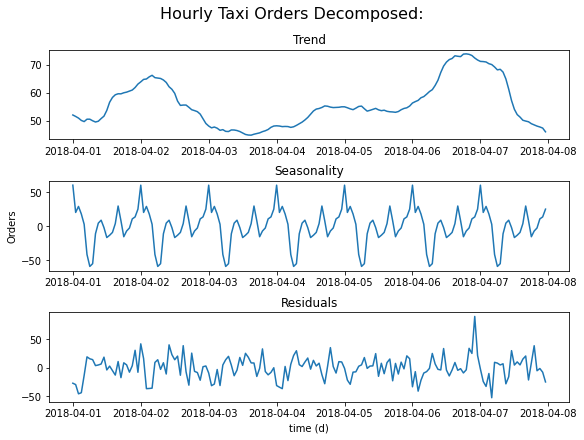

In [11]:
decomposed = seasonal_decompose(data_og)

fig, ax = plt.subplots(3, 1,figsize=(8,6) ,constrained_layout=True)
fig.suptitle('Hourly Taxi Orders Decomposed:', fontsize=16)

ax[0].plot(decomposed.trend['2018-04-01':'2018-04-07'])
ax[0].set_title('Trend')

ax[1].plot(decomposed.seasonal['2018-04-01':'2018-04-07'])
ax[1].set_title('Seasonality')
ax[1].set_ylabel('Orders')

ax[2].plot(decomposed.resid['2018-04-01':'2018-04-07'])
ax[2].set_title('Residuals')
ax[2].set_xlabel('time (d)');


* The weekly trend is more orders on Saturday(7/4/18) and Monday(2/4/18).
* Looks like there is a strong seasonality in the daily orders, with difference between the daily peak and daily low of ~100 orders.

## Preparation
* I will create more features to assist the models learning.

In [12]:
def make_features(data, max_lag, rolling_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['change'] = data['num_orders'].shift().diff()
    data['change_rate'] = data['num_orders'].shift().pct_change(periods = rolling_size)
    data['change_rate'][data['change_rate'] == np.inf] = 1
    data['change_rate'][data['change_rate'] == -np.inf] = -1
    
    data['rolling_{}'.format(rolling_size)] = data['num_orders'].shift().rolling(rolling_size).mean()
    data['rolling_{}'.format(rolling_size*2)] = data['num_orders'].shift().rolling(rolling_size*2).mean()

    data['rolling_{}H'.format(rolling_size)] = data['num_orders'].shift().rolling(rolling_size).max()
    data['rolling_{}L'.format(rolling_size)] = data['num_orders'].shift().rolling(rolling_size).min()
    
    data['momentum'] = 100*((data['num_orders'].shift() - data['rolling_{}L'.format(rolling_size)]) / (data['rolling_{}H'.format(rolling_size)] - data['rolling_{}L'.format(rolling_size)]))
    data['r_percent'] = ((data['rolling_{}H'.format(rolling_size)] - data['num_orders'].shift()) / (data['rolling_{}H'.format(rolling_size)] - data['rolling_{}L'.format(rolling_size)])) * - 100
    
    data['MACD'] = data['rolling_{}'.format(rolling_size)] - data['rolling_{}'.format(rolling_size*2)]
    data['MACD_EMA'] = data['MACD'].rolling(round(rolling_size/2)).mean()
    
    return data

In [13]:
data = make_features(data_og, 7, 14)

## Analysis

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,change,change_rate,rolling_14,rolling_28,rolling_14H,rolling_14L,momentum,r_percent,MACD,MACD_EMA
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,...,18.0,3.400000,160.785714,170.214286,217.0,46.0,63.157895,-36.842105,-9.428571,-19.525510
2018-08-31 22:00:00,223,8,31,4,22,159.0,154.0,136.0,207.0,217.0,...,5.0,2.456522,168.857143,163.678571,217.0,116.0,42.574257,-57.425743,5.178571,-16.403061
2018-08-31 23:00:00,205,8,31,4,23,223.0,159.0,154.0,136.0,207.0,...,64.0,0.225275,171.785714,165.321429,223.0,116.0,100.000000,-0.000000,6.464286,-12.505102


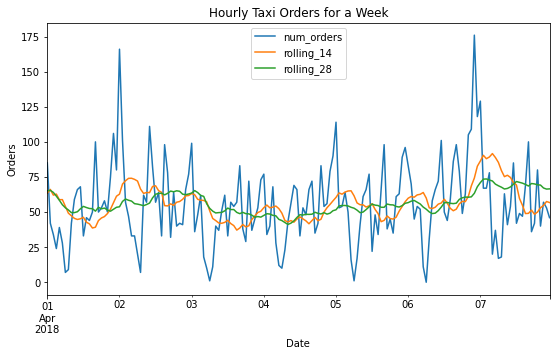

In [14]:
data['2018-04-01':'2018-04-07'][['num_orders','rolling_14', 'rolling_28']].plot(
    figsize=(9, 5),
    title= 'Hourly Taxi Orders for a Week',
    ylabel='Orders',
    xlabel='Date');

data.tail(3)

* Data is looking good and ready for testing.

## Training and Testing

In [15]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)
target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

In [16]:
def model_evaluation( model ):
    t0= time.time()
    
    model.fit(features_train, target_train)
    t1= time.time()

    predictions2 = model.predict(features_test)
    t2= time.time()
    
    predictions1 = model.predict(features_train)

    RMSE1 = mean_squared_error(target_train, predictions1)**0.5
    RMSE2 = mean_squared_error(target_test, predictions2)**0.5
  
    score= {'training_rmse': [RMSE1],
            'test_rmse': [RMSE2],
            'training_time': [t1 - t0],
            'prediction_time': [t2 - t1] ,
            'total_time': [t2 - t0]
           }  

    return pd.DataFrame(score)

In [12]:
%%time

list_of_models = [LinearRegression(),
                  DecisionTreeRegressor(),
                  RandomForestRegressor(),
                  CatBoostRegressor(loss_function="RMSE", iterations=50),
                  xgb.XGBRegressor()]

model_score_ev =  pd.DataFrame()
for mod in list_of_models:
    model_score_ev = model_score_ev.append(model_evaluation(mod))

Learning rate set to 0.5
0:	learn: 32.2949418	total: 53.6ms	remaining: 2.63s
1:	learn: 29.6831824	total: 59.7ms	remaining: 1.43s
2:	learn: 26.6484770	total: 66.3ms	remaining: 1.04s
3:	learn: 25.3195279	total: 72.7ms	remaining: 836ms
4:	learn: 24.8175752	total: 77.3ms	remaining: 696ms
5:	learn: 24.0849302	total: 83.6ms	remaining: 613ms
6:	learn: 23.8778893	total: 89.8ms	remaining: 552ms
7:	learn: 23.6626803	total: 95.9ms	remaining: 503ms
8:	learn: 23.4693693	total: 102ms	remaining: 464ms
9:	learn: 23.2475660	total: 107ms	remaining: 429ms
10:	learn: 22.5342804	total: 112ms	remaining: 396ms
11:	learn: 22.0930606	total: 115ms	remaining: 365ms
12:	learn: 21.9013693	total: 119ms	remaining: 340ms
13:	learn: 21.6493316	total: 123ms	remaining: 317ms
14:	learn: 21.5843876	total: 128ms	remaining: 299ms
15:	learn: 21.4265077	total: 132ms	remaining: 280ms
16:	learn: 21.3205892	total: 135ms	remaining: 263ms
17:	learn: 21.0694168	total: 139ms	remaining: 247ms
18:	learn: 20.7579160	total: 143ms	remain

## Conclusion

In [13]:
model_score_ev.index = ['LinearRegression', 
                        'DecisionTreeRegressor', 
                        'RandomForestRegressor',
                        'CatBoostRegressor',
                        'XGBRegressor']

model_score_ev[['training_rmse','test_rmse','total_time']].sort_values(by = "test_rmse")

,training_rmse,test_rmse,total_time
RandomForestRegressor,8.534623,44.305405,3.591110
XGBRegressor,5.807784,44.854331,115.620917
CatBoostRegressor,16.181222,45.021604,0.626724
LinearRegression,29.924378,52.294819,0.202880
DecisionTreeRegressor,0.000000,54.559818,0.236787


* The best model for predicting next hour number of taxi orders is: RandomForestRegressor.
* RandomForestRegressor has the best precision.
* CatBoostRegressor is the fastest model that pass the RMSE creteria.